## Imports and constants

In [2]:
%matplotlib ipympl

import os
import numpy as np
import scipy.stats as st
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

from onix.data_tools import get_experiment_data, open_analysis_folder, get_analysis_file_path
from onix.analysis.fitter import Fitter
from onix.helpers import data_identifier, console_bold, present_float

In [3]:
name = "Fluorescence Decay"
analysis_number = None
identifier = None

In [4]:
def add_label(ax, x=0.02, y=1.1):
    ax.text(x, y, identifier, transform=ax.transAxes)

In [5]:
class FluorescenceDecay:
    def __init__(self, data_signal):
        self._data_signal = data_signal
        self._excitation_time = self._data_signal[1]["excitation_time"].to("s").magnitude
        self.freq = self._data_signal[1]["frequency"]
        try:
            self.normalizer = self._data_signal[1]["normalizer"]
        except KeyError:
            self.normalizer = None
        self._excitation_delay = self._data_signal[1]["excitation_delay"].to("s").magnitude
        self._average_data()
        
    def _average_data(self):
        self._times = self._data_signal[0]["pmt_times"]
        self.times_ms = self._times * 1e3
        signal_voltages = self._data_signal[0]["pmt_voltages"]
        self.V_signal_avg = np.average(signal_voltages, axis=0)
        self.V_signal_err = np.std(signal_voltages, axis=0) / np.sqrt(len(signal_voltages))
    
    def get_test_data(self, test_time=(500e-6), offset_time=100e-6, excitation_delay=10e-6):
        test_start_time = offset_time * 2 
        test_end_time = offset_time * 2 + test_time + excitation_delay * 2
        test_mask = np.bitwise_and(
            self._times > test_start_time,
            self._times <= test_end_time,
        )
        self._test_end = test_end_time + offset_time
        self.test_times_ms = self.times_ms[test_mask]
        self.V_signal_test_avg = self.V_signal_avg[test_mask]
        self.V_signal_test_err = self.V_signal_err[test_mask]

    def get_decay_data(self):
        decay_start_time = self._test_end + self._excitation_delay * 2 + self._excitation_time
        decay_mask = self._times > decay_start_time
        decay_start_time_ms = decay_start_time * 1e3
        self.decay_times_ms = self.times_ms[decay_mask] - decay_start_time_ms
        self.V_signal_decay_avg = self.V_signal_avg[decay_mask]
        self.V_signal_decay_err = self.V_signal_err[decay_mask]

## Setup

In [49]:
data_numbers = [515293]
data = FluorescenceDecay(get_experiment_data(data_numbers[0]))
identifier = "data " + data_identifier(data_numbers) + ", analysis " + data_identifier([analysis_number])

In [50]:
if input(f"Create new analysis folder? (y/{console_bold('n')}) ") == "y":
    analysis_number = open_analysis_folder(name)
else:
    if input(f"Keep current analysis number of {analysis_number}? ({console_bold('y')}/n) ") == "n":
        analysis_number = int(input("Enter analysis number: "))
identifier = "data " + data_identifier(data_numbers) +", analysis " + data_identifier([analysis_number])
print(f"Current analysis number is {analysis_number}")

Create new analysis folder? (y/n)  y


Current analysis number is 606


## Overall plot

[0.000e+00 1.000e-03 2.000e-03 ... 8.497e+00 8.498e+00 8.499e+00]
[ 0.18630859  0.24771533  0.26274658 ... -0.00060986 -0.00062598
 -0.00067627]


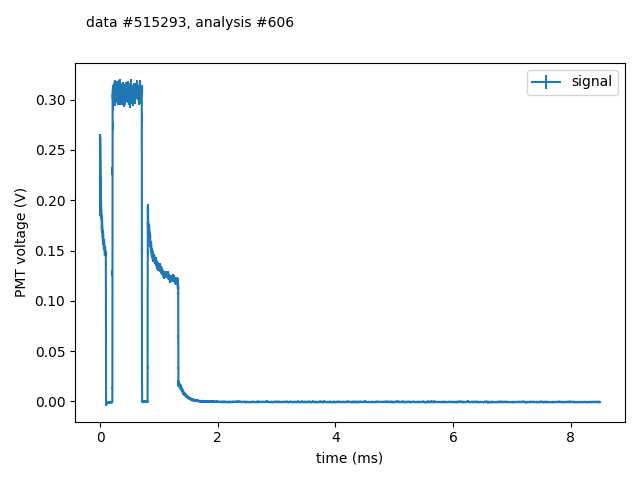

In [51]:
print(data.times_ms)
print(data.V_signal_avg)
fig, ax = plt.subplots()
add_label(ax)
ax.errorbar(data.times_ms, data.V_signal_avg, data.V_signal_err, label="signal")
ax.set_xlabel("time (ms)")
ax.set_ylabel("PMT voltage (V)")
#ax.set_ylim(0.007, 0.008)
ax.legend()
plt.tight_layout()
plt.savefig(get_analysis_file_path(analysis_number, str(analysis_number) + "_signal_and_background.pdf"))
plt.show()

## Test data

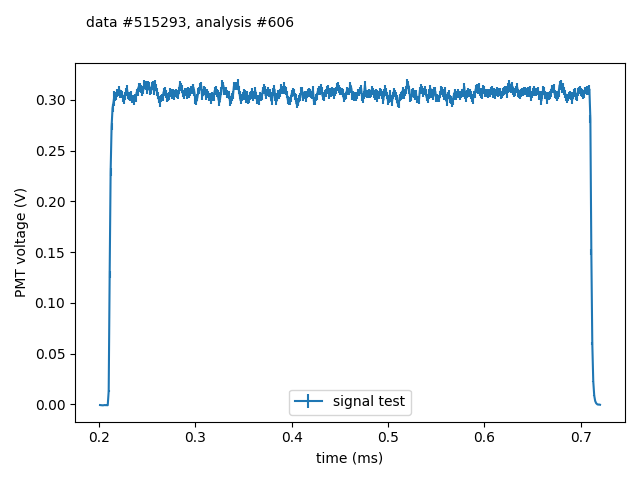

In [52]:
data.get_test_data()
fig, ax = plt.subplots()
add_label(ax)
ax.errorbar(data.test_times_ms, data.V_signal_test_avg, data.V_signal_test_err, label="signal test")
ax.set_xlabel("time (ms)")
ax.set_ylabel("PMT voltage (V)")
ax.legend()
plt.tight_layout()
plt.savefig(get_analysis_file_path(analysis_number, str(analysis_number) + "_test.pdf"))
plt.show()

## decay data

In [53]:
def exp_decay(t, tau, a, c):
    return np.exp(-t / tau) * a + c

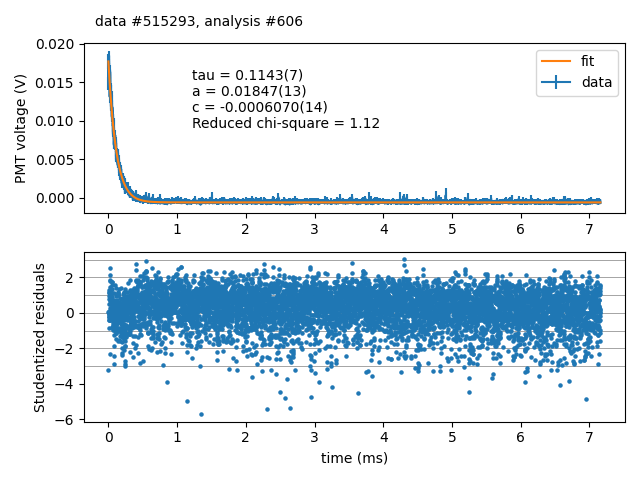

In [54]:
data.get_decay_data()

fitter = Fitter(exp_decay)
fitter.set_data(data.decay_times_ms, data.V_signal_decay_avg, data.V_signal_decay_err)
fitter.set_p0({"tau": 0.1, "a": 10, "c": 0})
fitter.fit()

fig, (ax, ax1) = plt.subplots(2, 1)

add_label(ax)
ax.errorbar(data.decay_times_ms, data.V_signal_decay_avg, data.V_signal_decay_err, label="data")
ax.plot(data.decay_times_ms, fitter.fitted_value(data.decay_times_ms), label="fit", zorder=50)
ax.text(0.2, 0.5, fitter.all_results_str(), transform=ax.transAxes)
ax.legend()



ax1.scatter(data.decay_times_ms, fitter.studentized_residuals(), s=5)
ax1.set_xlim(*ax.get_xlim())
ax1.use_sticky_edges = True
ax1.hlines([-3, -2, -1, 0, 1, 2, 3], *ax1.get_xlim(), zorder=0, color="grey", linewidth=0.5)
ax1.use_sticky_edges = False
ax1.set_xlabel("time (ms)")
ax1.set_ylabel("Studentized residuals")
ax.set_ylabel("PMT voltage (V)")


plt.tight_layout()
plt.savefig(get_analysis_file_path(analysis_number, str(analysis_number) + "_decay.pdf"))
plt.show()

## Spectroscopy

In [5]:
#data_numbers = [212823,212824,212825,212826,212827,212828,212829,212830,212831,212832]
data_numbers = list(range(246501, 246650))#list(range(246115,246151))#
data = dict([(
    kk,
    FluorescenceDecay(get_experiment_data(kk))
) for kk in data_numbers])

intensity_data = []

for kk in data_numbers:
    data[kk].get_test_data()
    data[kk].get_decay_data()
    #max_index = np.argmax(data[kk].V_signal_decay_avg)
    signal_data = data[kk].V_signal_decay_avg
    #print(signal_data[0])
    amplitude = np.average(signal_data[0:10])-np.average(signal_data[(len(signal_data)-1)//3: 2 * (len(signal_data)-1)//3])
    #amplitude_err = data[kk].V_signal_decay_err[max_index]

    normalize_data = data[kk].V_signal_test_avg
    normalizer = np.average(normalize_data[(len(normalize_data)-1)//3: 2 * (len(normalize_data)-1)//3])
    freq = data[kk].freq
    if normalizer == None:
        intensity_data.append([amplitude, freq])
    else:
        if normalizer > 0.1:
            intensity_data.append([amplitude/normalizer, freq])
        else:
            intensity_data.append([np.nan, freq])
            print(kk)
    # print(amplitude/normalizer, normalizer)
intensity_data = np.array(intensity_data).T


In [6]:
if input(f"Create new analysis folder? (y/{console_bold('n')}) ") == "y":
    analysis_number = open_analysis_folder(name)
else:
    if input(f"Keep current analysis number of {analysis_number}? ({console_bold('y')}/n) ") == "n":
        analysis_number = int(input("Enter analysis number: "))
identifier = "data " + data_identifier(data_numbers) +", analysis " + data_identifier([analysis_number])
print(f"Current analysis number is {analysis_number}")


Create new analysis folder? (y/n)  y


Current analysis number is 524


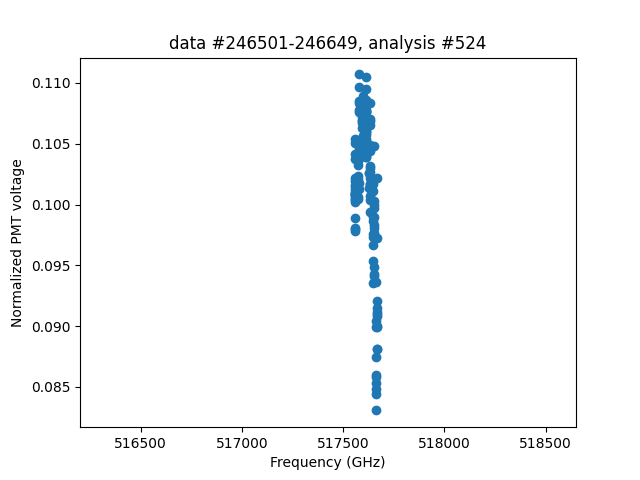

In [7]:
fig, ax = plt.subplots()
ax.scatter(intensity_data[1], intensity_data[0])
ax.set_xlabel("Frequency (GHz)")
ax.set_ylabel("Normalized PMT voltage")
#ax.set_ylim([-0.01,0.15])
ax.set_xlim([516200, 518650])
ax.set_title(identifier)
plt.savefig(get_analysis_file_path(analysis_number, str(analysis_number) + "_fluorescence_vs_freq.pdf"))
plt.show()

## Melting Scans

In [10]:
data_numbers = list(range(514736,515249))
data = dict([(
    kk,
    FluorescenceDecay(get_experiment_data(kk))
) for kk in data_numbers])

intensity_data = []
transmission_data = []
for kk in data_numbers:
    data[kk].get_test_data()
    data[kk].get_decay_data()
    #max_index = np.argmax(data[kk].V_signal_decay_avg)
    signal_data = data[kk].V_signal_decay_avg
    #print(signal_data[0])
    amplitude = np.average(signal_data[0:10])-np.average(signal_data[(len(signal_data)-1)//3: 2 * (len(signal_data)-1)//3])
    #amplitude_err = data[kk].V_signal_decay_err[max_index]

    normalize_data = data[kk].V_signal_test_avg
    normalizer = np.average(normalize_data[(len(normalize_data)-1)//3: 2 * (len(normalize_data)-1)//3])
    time = np.min(data[kk]._data_signal[0]["epoch_times"])
    transmission = data[kk]._data_signal[1]["transmission"]
    if normalizer == None:
        intensity_data.append([amplitude, freq])
    else:
        if normalizer > 0.03:
            intensity_data.append([amplitude/normalizer, time, np.average(transmission)/normalizer])
        else:
            intensity_data.append([np.nan, time, np.average(transmission)/normalizer])
            print(kk)
    #print(amplitude/normalizer, normalizer)
intensity_data = np.array(intensity_data).T


514753
514754
514755
514756
514757
514758
514759
514760
514761
514762
514763
514764
514765
514766
514767
514768
514769
514770
514771
514772
514773
514774
514775
514776
514777
514778
514779
514780
514781
514782
514783
514784
514785
514786
514787
514788
514789
514790
514803
514804
514819
514820
514861
514862
514871
514872
514873
514874
514887
514888
514889
514890
514902
514903
514904
514915
514916
514928
514931
514932
514941
514944
514958
514959
514960
514970
514972
514985
514986
514987
514988
514998
515000
515001
515002
515013
515015
515016
515028
515029
515030
515043
515044
515056
515057
515058
515070
515071
515072
515083
515084
515085
515086
515097
515098
515112
515113
515114
515125


In [152]:
if input(f"Create new analysis folder? (y/{console_bold('n')}) ") == "y":
    analysis_number = open_analysis_folder(name)
else:
    if input(f"Keep current analysis number of {analysis_number}? ({console_bold('y')}/n) ") == "n":
        analysis_number = int(input("Enter analysis number: "))
identifier = "data " + data_identifier(data_numbers) +", analysis " + data_identifier([analysis_number])
print(f"Current analysis number is {analysis_number}")

Create new analysis folder? (y/n)  y


Current analysis number is 558


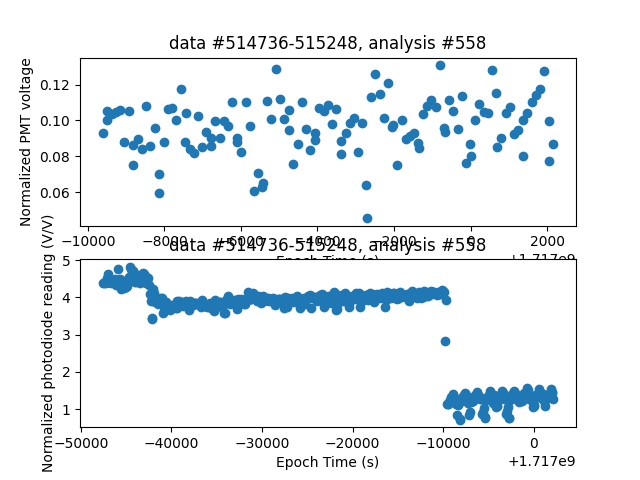

In [153]:
fig, ax = plt.subplots(2,1)
ax[0].scatter(intensity_data[1], intensity_data[0])
ax[0].set_xlabel("Epoch Time (s)")
ax[0].set_ylabel("Normalized PMT voltage")
#ax.set_ylim([-0.01,0.15])
ax[0].set_title(identifier)


ax[1].scatter(intensity_data[1],intensity_data[2])
ax[1].set_xlabel("Epoch Time (s)")
ax[1].set_ylabel("Normalized photodiode reading (V/V)")
#ax.set_ylim([-0.01,0.15])
ax[1].set_title(identifier)

plt.savefig(get_analysis_file_path(analysis_number, str(analysis_number) + "_fluorescence_vs_freq.pdf"))
plt.show()

## Time bucketed melting scans

In [43]:
data_numbers = list(range(515281,515787)) # list(range(514736,515249))
data = dict([(
    kk,
    FluorescenceDecay(get_experiment_data(kk))
) for kk in data_numbers])

intensity_data = []
transmission_data = []
for kk in data_numbers:
    data[kk].get_test_data()
    data[kk].get_decay_data()
    #max_index = np.argmax(data[kk].V_signal_decay_avg)
    signal_data = data[kk].V_signal_decay_avg
    #print(signal_data[0])
    amplitude = np.average(signal_data[0:10])-np.average(signal_data[(len(signal_data)-1)//3: 2 * (len(signal_data)-1)//3])
    #amplitude_err = data[kk].V_signal_decay_err[max_index]

    normalize_data = data[kk].V_signal_test_avg
    normalizer = np.average(normalize_data[(len(normalize_data)-1)//3: 2 * (len(normalize_data)-1)//3])
    time_bucket = data[kk]._data_signal[1]["time_bucket"]
    time = np.min(data[kk]._data_signal[0]["epoch_times"])
    transmission = data[kk]._data_signal[1]["transmission"]
    freq = data[kk]._data_signal[1]["frequency"]
    if normalizer == None:
        intensity_data.append([amplitude, freq])
    else:
        if normalizer > 0.01:
            intensity_data.append([amplitude/normalizer, np.average(transmission)/normalizer, time_bucket, time, freq])
        else:
            intensity_data.append([np.nan, np.average(transmission), time_bucket, time, freq])
            print(kk)
    #print(amplitude/normalizer, normalizer)
intensity_data = np.array(intensity_data).T
# print(intensity_data)

In [44]:
if input(f"Create new analysis folder? (y/{console_bold('n')}) ") == "y":
    analysis_number = open_analysis_folder(name)
else:
    if input(f"Keep current analysis number of {analysis_number}? ({console_bold('y')}/n) ") == "n":
        analysis_number = int(input("Enter analysis number: "))
identifier = "data " + data_identifier(data_numbers) +", analysis " + data_identifier([analysis_number])
print(f"Current analysis number is {analysis_number}")

Create new analysis folder? (y/n)  n
Keep current analysis number of 603? (y/n)  y


Current analysis number is 603


In [15]:
## Parked Freq

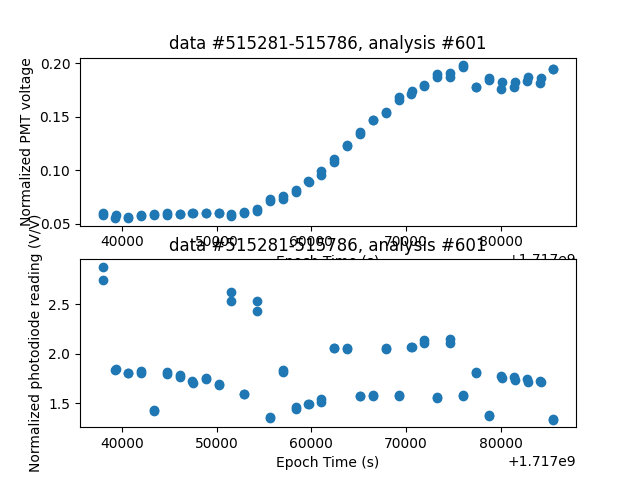

In [16]:
fig, ax = plt.subplots(2,1)
chosen_freq = 517664
freq_index = np.where(np.abs(intensity_data[4] - chosen_freq)<=5)
filtered_data = [intensity_data[i][freq_index] for i in range(len(intensity_data))]
ax[0].scatter(filtered_data[3], filtered_data[0])
ax[0].set_xlabel("Epoch Time (s)")
ax[0].set_ylabel("Normalized PMT voltage")
#ax.set_ylim([-0.01,0.15])
ax[0].set_title(identifier)


ax[1].scatter(filtered_data[3],filtered_data[1])
ax[1].set_xlabel("Epoch Time (s)")
ax[1].set_ylabel("Normalized photodiode reading (V/V)")
#ax.set_ylim([-0.01,0.15])
ax[1].set_title(identifier)

plt.savefig(get_analysis_file_path(analysis_number, str(analysis_number) + "_fluorescence_vs_freq.pdf"))
plt.show()

## Time Bucketed Peaks

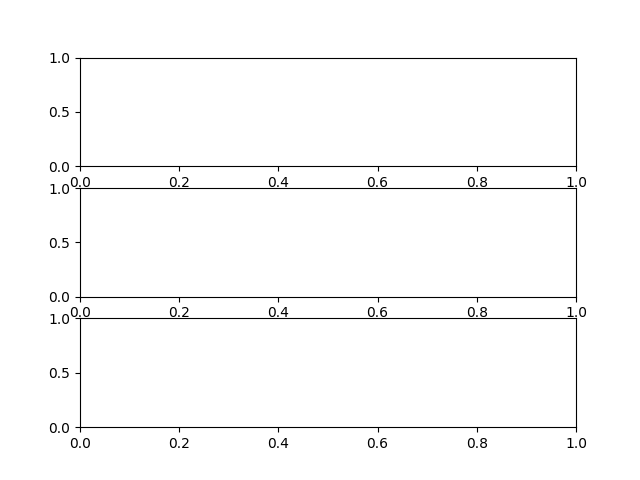

Text(0.5, 1.0, 'data #515281-515786, analysis #603')

In [41]:
"""for i in range(len(intensity_data[2])):
    intensity_data[2][i]= np.floor(i/14)
"""

fig, ax = plt.subplots(3,1)
#print(intensity_data[0])
plt.savefig(get_analysis_file_path(analysis_number, str(analysis_number) + "_fluorescence_vs_freq.pdf"))
plt.show()

"""
for i in range(int(np.max(intensity_data[2]))):
    j= i + 1
    bucket_index = np.where(intensity_data[2] == j)
    filtered_data = [intensity_data[kk][bucket_index] for kk in range(len(intensity_data))]
    ax[0].scatter(filtered_data[4], filtered_data[0], label = "Bucket number"+ str(j))
    ax[0].set_xlabel("Frequency (GHz)")
    ax[0].set_ylabel("Normalized PMT voltage")
    ax[0].legend()
    ax[0].set_title(identifier)
    
    
    ax[1].scatter(filtered_data[4],filtered_data[1])
    ax[1].set_xlabel("Frequency (GHz)")
    ax[1].set_ylabel("Transmission Photodiode Reading")
    #ax.set_ylim([-0.01,0.15])
    # ax[1].set_title(identifier)
"""

bucket_num = 21

bucket_index = np.where(intensity_data[2] == bucket_num)
filtered_data = [intensity_data[kk][bucket_index] for kk in range(len(intensity_data))]
ax[0].scatter(filtered_data[4][0:6], filtered_data[0][0:6], label = "Bucket number"+ str(bucket_num))
ax[0].set_xlabel("Frequency (GHz)")
ax[0].set_ylabel("Normalized PMT voltage")
ax[0].legend()
ax[0].set_title(identifier)

bucket_index = np.where(intensity_data[2] == bucket_num)
filtered_data = [intensity_data[kk][bucket_index] for kk in range(len(intensity_data))]
ax[1].scatter(filtered_data[4][7:13], filtered_data[0][7:13], label = "Bucket number"+ str(bucket_num))
ax[1].set_xlabel("Frequency (GHz)")
ax[1].set_ylabel("Normalized PMT voltage")
ax[1].legend()
ax[1].set_title(identifier)

bucket_index = np.where(intensity_data[2] == bucket_num)
filtered_data = [intensity_data[kk][bucket_index] for kk in range(len(intensity_data))]
ax[2].scatter(filtered_data[4], filtered_data[0], label = "Bucket number"+ str(bucket_num))
ax[2].set_xlabel("Frequency (GHz)")
ax[2].set_ylabel("Normalized PMT voltage")
ax[2].legend()
ax[2].set_title(identifier)


#ax[1].scatter(filtered_data[4],filtered_data[1])
#ax[1].set_xlabel("Frequency (GHz)")
#ax[1].set_ylabel("Transmission Photodiode Reading")


In [18]:
def parabolic_fit(x, a,f0, c):
    return a*(x-f0)**2+c

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35]


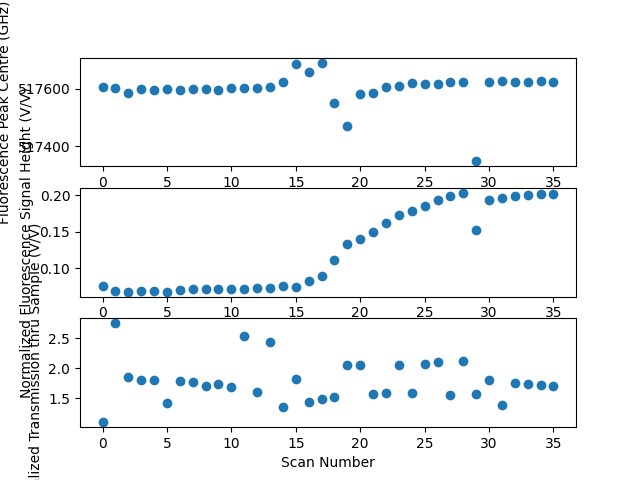

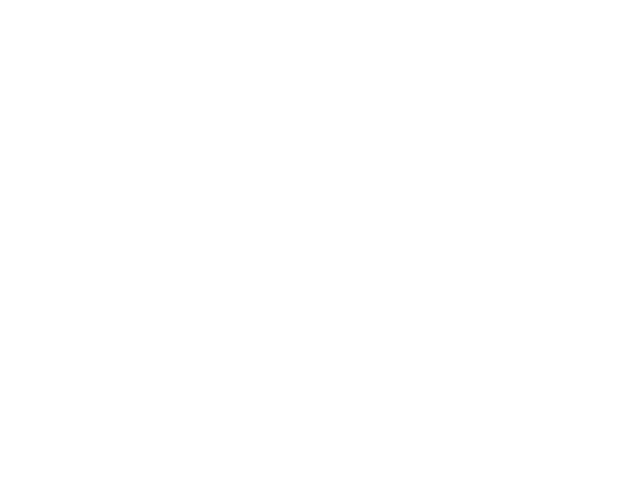

In [48]:
parabolic_fitter = Fitter(parabolic_fit)
num_buckets = int(np.max(intensity_data[2]))

plt.figure()
peak_centers = []
peak_heights = []
bucket_number = []
transmission_intensity = []
fig, ax = plt.subplots(3,1)
for kk in range(num_buckets):
    bucket_index = np.where(intensity_data[2] == kk)
    filtered_data = [intensity_data[kk][bucket_index] for kk in range(len(intensity_data))]
    #print(len(filtered_data[0]))
    x_data = filtered_data[4][0:6] # to use only one direction of the scan put [0:6] after
    y_data = filtered_data[0][0:6] # [0:6]
    try:
        parabolic_fitter.set_data(x_data, y_data)
        parabolic_fitter.set_absolute_sigma(False)
        parabolic_fitter.set_p0({"f0": 517600})
        parabolic_fitter.fit()
        test_vals = np.arange(517560,517670, 1)
        peak_heights.append(parabolic_fitter.results["c"])
        peak_centers.append(parabolic_fitter.results["f0"])
        bucket_number.append(kk)
        transmission_intensity.append(filtered_data[1][0])
        if kk == 100:
            ax[0].scatter(x_data, y_data)
            ax[0].plot(test_vals, parabolic_fitter.fitted_value(test_vals))
    except RuntimeError:
        print(kk)
print(bucket_number)
ax[0].scatter(bucket_number, peak_centers)
ax[0].set_xlabel("Scan Number")
ax[0].set_ylabel("Fluorescence Peak Centre (GHz)")

ax[1].scatter(bucket_number, peak_heights)
ax[1].set_xlabel("Scan Number")
ax[1].set_ylabel("Normalized Fluorescence Signal Height (V/V)")

ax[2].scatter(bucket_number, transmission_intensity)
ax[2].set_xlabel("Scan Number")
ax[2].set_ylabel("Normalized Transmission thru Sample (V/V)")
plt.savefig(get_analysis_file_path(analysis_number, str(analysis_number) + "_fluorescence_linecentre_during_transition.pdf"))
plt.show()